# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

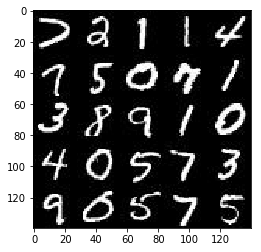

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

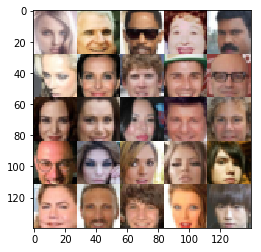

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 ?
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x3, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x256 ?
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x1 = tf.image.resize_nearest_neighbor(x1, (7,7))
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x2 = tf.image.resize_nearest_neighbor(x2, (14,14))
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        x3 = tf.image.resize_nearest_neighbor(x3, (28,28))
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out  
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


In [11]:
class GAN:
    def __init__(self, real_dim, z_dim, learning_rate, beta1=0.5):
#         tf.reset_default_graph()        
        self.input_real, self.input_z, self.learning_rate = model_inputs(real_dim[1], real_dim[2], real_dim[3], z_dim)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_dim[-1])
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    net = GAN(data_shape, z_dim, learning_rate=learning_rate, beta1=beta1)

#     saver = tf.train.Saver()
    steps = 0 
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_real in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={
                    net.input_real: batch_real, 
                    net.input_z: batch_z,
                    net.learning_rate: learning_rate
                })
                _ = sess.run(net.g_opt, feed_dict={
                    net.input_real: batch_real,
                    net.input_z: batch_z,
                    net.learning_rate: learning_rate
                })


                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_real})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 36, net.input_z, data_shape[-1], data_image_mode)
#         saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7730... Generator Loss: 0.2679
Epoch 1/2... Discriminator Loss: 3.8330... Generator Loss: 0.0509
Epoch 1/2... Discriminator Loss: 2.7009... Generator Loss: 0.0901
Epoch 1/2... Discriminator Loss: 2.9551... Generator Loss: 0.1409
Epoch 1/2... Discriminator Loss: 2.1984... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 1.9366... Generator Loss: 0.2627
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 1.2267


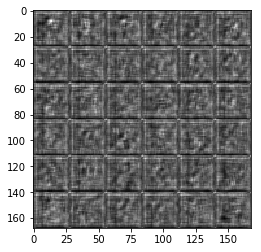

Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.3495
Epoch 1/2... Discriminator Loss: 0.7454... Generator Loss: 1.2099
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 0.5942... Generator Loss: 1.2949
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 2.0238
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.9280
Epoch 1/2... Discriminator Loss: 1.9496... Generator Loss: 0.2039
Epoch 1/2... Discriminator Loss: 1.7108... Generator Loss: 0.2959
Epoch 1/2... Discriminator Loss: 2.0371... Generator Loss: 0.2081
Epoch 1/2... Discriminator Loss: 1.8548... Generator Loss: 0.2955


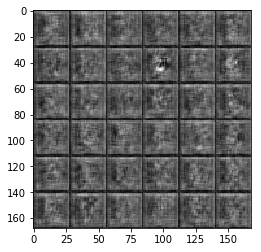

Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 1.5266
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.4090
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.3244
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 1.2278


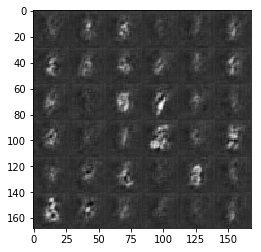

Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 1.4504
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.1348
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 2.4454
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 2.2582


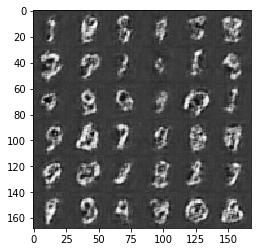

Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 1.4890
Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 0.9289
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.3284
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.5762
Epoch 1/2... Discriminator Loss: 0.6377... Generator Loss: 1.3635
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 2.0710
Epoch 1/2... Discriminator Loss: 0.5511... Generator Loss: 2.9600
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 0.3857... Generator Loss: 2.6867
Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 1.5072


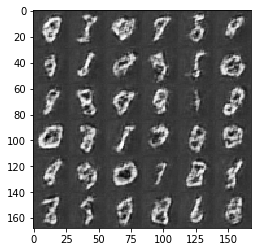

Epoch 1/2... Discriminator Loss: 0.3900... Generator Loss: 1.5519
Epoch 1/2... Discriminator Loss: 0.4550... Generator Loss: 2.7147
Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 1.3422
Epoch 1/2... Discriminator Loss: 0.2328... Generator Loss: 2.3723
Epoch 1/2... Discriminator Loss: 0.2524... Generator Loss: 2.1258
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.3245
Epoch 1/2... Discriminator Loss: 0.2334... Generator Loss: 2.4222
Epoch 1/2... Discriminator Loss: 0.3481... Generator Loss: 2.0985
Epoch 1/2... Discriminator Loss: 0.5110... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 0.2398... Generator Loss: 2.2814


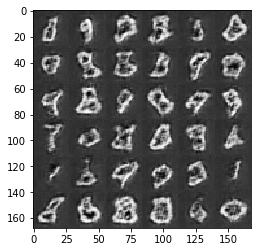

Epoch 1/2... Discriminator Loss: 0.1948... Generator Loss: 3.6095
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 0.2027... Generator Loss: 2.8789
Epoch 1/2... Discriminator Loss: 0.1816... Generator Loss: 2.6036
Epoch 1/2... Discriminator Loss: 0.2942... Generator Loss: 1.7322
Epoch 1/2... Discriminator Loss: 0.0850... Generator Loss: 3.4916
Epoch 1/2... Discriminator Loss: 0.1542... Generator Loss: 2.9614
Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 2.2072
Epoch 1/2... Discriminator Loss: 0.1050... Generator Loss: 4.0447
Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 3.3375


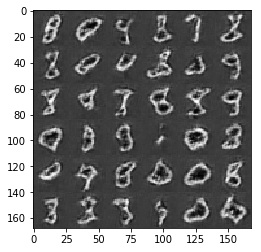

Epoch 1/2... Discriminator Loss: 0.1951... Generator Loss: 2.3019
Epoch 1/2... Discriminator Loss: 0.1085... Generator Loss: 2.6638
Epoch 1/2... Discriminator Loss: 0.1016... Generator Loss: 4.8574
Epoch 1/2... Discriminator Loss: 4.0866... Generator Loss: 0.0256
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 2.2141
Epoch 1/2... Discriminator Loss: 0.2108... Generator Loss: 2.3959
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 0.2097... Generator Loss: 2.2580
Epoch 1/2... Discriminator Loss: 0.2222... Generator Loss: 2.3428


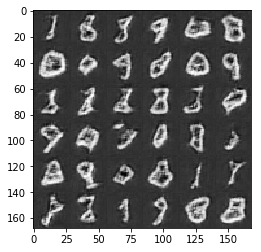

Epoch 1/2... Discriminator Loss: 0.1368... Generator Loss: 2.7665
Epoch 1/2... Discriminator Loss: 0.1796... Generator Loss: 2.2215
Epoch 1/2... Discriminator Loss: 0.0902... Generator Loss: 4.5193
Epoch 1/2... Discriminator Loss: 0.0569... Generator Loss: 4.1031
Epoch 1/2... Discriminator Loss: 0.1274... Generator Loss: 3.4959
Epoch 1/2... Discriminator Loss: 0.0623... Generator Loss: 4.5297
Epoch 1/2... Discriminator Loss: 0.0805... Generator Loss: 4.5100
Epoch 1/2... Discriminator Loss: 0.1267... Generator Loss: 2.7402
Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.7908
Epoch 1/2... Discriminator Loss: 0.1042... Generator Loss: 5.2640


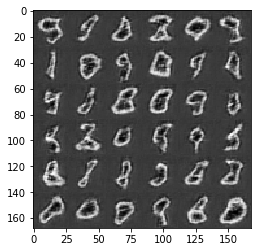

Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 1.9482
Epoch 1/2... Discriminator Loss: 0.1137... Generator Loss: 2.7496
Epoch 1/2... Discriminator Loss: 0.1505... Generator Loss: 2.8539
Epoch 2/2... Discriminator Loss: 0.1100... Generator Loss: 3.2396
Epoch 2/2... Discriminator Loss: 0.0659... Generator Loss: 4.2758
Epoch 2/2... Discriminator Loss: 0.0346... Generator Loss: 4.7244
Epoch 2/2... Discriminator Loss: 0.0491... Generator Loss: 4.9704
Epoch 2/2... Discriminator Loss: 0.2073... Generator Loss: 2.0767
Epoch 2/2... Discriminator Loss: 0.1464... Generator Loss: 2.6126
Epoch 2/2... Discriminator Loss: 0.0932... Generator Loss: 2.9589


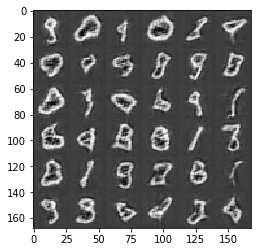

Epoch 2/2... Discriminator Loss: 0.0833... Generator Loss: 3.1234
Epoch 2/2... Discriminator Loss: 0.0885... Generator Loss: 3.4152
Epoch 2/2... Discriminator Loss: 2.9216... Generator Loss: 6.9513
Epoch 2/2... Discriminator Loss: 1.6112... Generator Loss: 1.6112
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 2.1315
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.4360
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 0.1861... Generator Loss: 2.5591


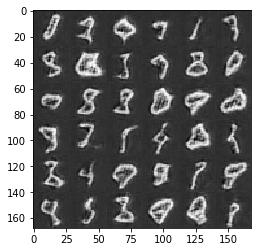

Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 3.4158
Epoch 2/2... Discriminator Loss: 0.2223... Generator Loss: 2.2492
Epoch 2/2... Discriminator Loss: 0.1241... Generator Loss: 3.4808
Epoch 2/2... Discriminator Loss: 0.4390... Generator Loss: 4.3964
Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 3.2273
Epoch 2/2... Discriminator Loss: 0.0861... Generator Loss: 3.1656
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 0.9103
Epoch 2/2... Discriminator Loss: 0.0650... Generator Loss: 3.9887
Epoch 2/2... Discriminator Loss: 0.0796... Generator Loss: 6.3876


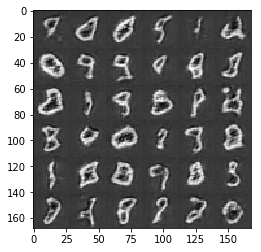

Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 3.0764
Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 2.4417
Epoch 2/2... Discriminator Loss: 0.0466... Generator Loss: 4.1625
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 7.7596
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 0.2389... Generator Loss: 1.9488
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.3949
Epoch 2/2... Discriminator Loss: 0.0769... Generator Loss: 5.4142
Epoch 2/2... Discriminator Loss: 0.1143... Generator Loss: 2.7329
Epoch 2/2... Discriminator Loss: 0.0744... Generator Loss: 5.2507


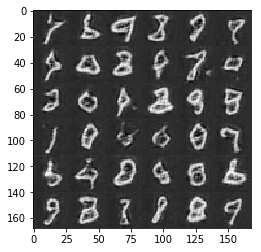

Epoch 2/2... Discriminator Loss: 0.1511... Generator Loss: 7.3850
Epoch 2/2... Discriminator Loss: 0.0841... Generator Loss: 3.5059
Epoch 2/2... Discriminator Loss: 0.0793... Generator Loss: 3.4261
Epoch 2/2... Discriminator Loss: 0.3021... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 4.0336
Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 0.0855... Generator Loss: 3.0647
Epoch 2/2... Discriminator Loss: 0.4408... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 0.0931... Generator Loss: 3.7115


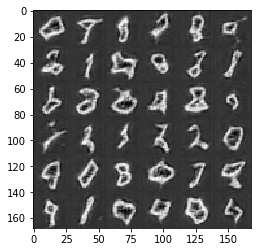

Epoch 2/2... Discriminator Loss: 0.4567... Generator Loss: 1.1796
Epoch 2/2... Discriminator Loss: 0.0897... Generator Loss: 3.9539
Epoch 2/2... Discriminator Loss: 0.2316... Generator Loss: 2.0898
Epoch 2/2... Discriminator Loss: 0.0970... Generator Loss: 2.9138
Epoch 2/2... Discriminator Loss: 0.1052... Generator Loss: 3.0478
Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 4.7430
Epoch 2/2... Discriminator Loss: 0.0427... Generator Loss: 4.4060
Epoch 2/2... Discriminator Loss: 0.0879... Generator Loss: 4.9604
Epoch 2/2... Discriminator Loss: 0.0545... Generator Loss: 5.0788
Epoch 2/2... Discriminator Loss: 0.3689... Generator Loss: 5.8842


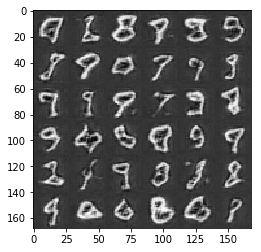

Epoch 2/2... Discriminator Loss: 0.0953... Generator Loss: 3.2568
Epoch 2/2... Discriminator Loss: 0.5437... Generator Loss: 1.0426
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 3.8498
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 4.6445
Epoch 2/2... Discriminator Loss: 0.0735... Generator Loss: 3.4115
Epoch 2/2... Discriminator Loss: 0.0585... Generator Loss: 4.0883
Epoch 2/2... Discriminator Loss: 0.7091... Generator Loss: 0.9973
Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 0.1054... Generator Loss: 3.6290
Epoch 2/2... Discriminator Loss: 0.2637... Generator Loss: 2.2223


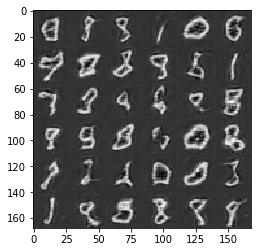

Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 1.6270
Epoch 2/2... Discriminator Loss: 0.0819... Generator Loss: 4.3496
Epoch 2/2... Discriminator Loss: 0.2040... Generator Loss: 2.0091
Epoch 2/2... Discriminator Loss: 0.1643... Generator Loss: 2.3110
Epoch 2/2... Discriminator Loss: 0.0731... Generator Loss: 5.2511
Epoch 2/2... Discriminator Loss: 0.0559... Generator Loss: 5.5686
Epoch 2/2... Discriminator Loss: 0.2296... Generator Loss: 2.0661
Epoch 2/2... Discriminator Loss: 0.0305... Generator Loss: 4.6181
Epoch 2/2... Discriminator Loss: 0.0418... Generator Loss: 5.4857
Epoch 2/2... Discriminator Loss: 0.1032... Generator Loss: 4.1368


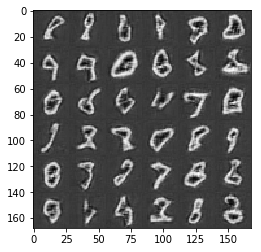

Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 3.7966
Epoch 2/2... Discriminator Loss: 0.1025... Generator Loss: 7.2839
Epoch 2/2... Discriminator Loss: 0.0959... Generator Loss: 3.0197
Epoch 2/2... Discriminator Loss: 0.0646... Generator Loss: 3.6205
Epoch 2/2... Discriminator Loss: 0.0746... Generator Loss: 3.6909
Epoch 2/2... Discriminator Loss: 0.0350... Generator Loss: 5.5902
Epoch 2/2... Discriminator Loss: 0.1812... Generator Loss: 2.2360
Epoch 2/2... Discriminator Loss: 0.0303... Generator Loss: 4.4631
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 10.7986
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 5.7889


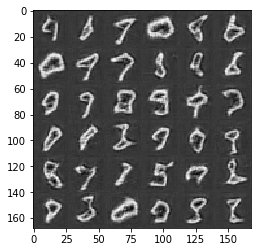

Epoch 2/2... Discriminator Loss: 0.0663... Generator Loss: 3.7229
Epoch 2/2... Discriminator Loss: 0.0443... Generator Loss: 4.2720
Epoch 2/2... Discriminator Loss: 0.1541... Generator Loss: 2.4815
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 5.1738
Epoch 2/2... Discriminator Loss: 0.0985... Generator Loss: 3.0801
Epoch 2/2... Discriminator Loss: 0.0937... Generator Loss: 2.7476
Epoch 2/2... Discriminator Loss: 0.0493... Generator Loss: 3.7225


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.8394... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.9558
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.4572


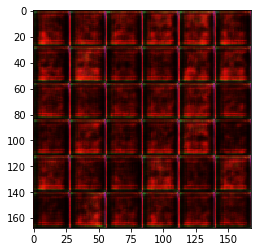

Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 1.2847
Epoch 1/2... Discriminator Loss: 0.4690... Generator Loss: 1.5051
Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 0.9261
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 0.4470... Generator Loss: 2.9279
Epoch 1/2... Discriminator Loss: 1.8964... Generator Loss: 0.2309
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.9143... Generator Loss: 7.2396
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 2.2329
Epoch 1/2... Discriminator Loss: 1.7217... Generator Loss: 0.5794


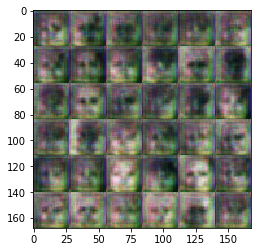

Epoch 1/2... Discriminator Loss: 2.7676... Generator Loss: 0.1100
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 0.9224
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 1.3664
Epoch 1/2... Discriminator Loss: 2.0911... Generator Loss: 0.1911
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 2.2307
Epoch 1/2... Discriminator Loss: 2.4189... Generator Loss: 0.1367
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 0.4928... Generator Loss: 2.4634
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 2.5978


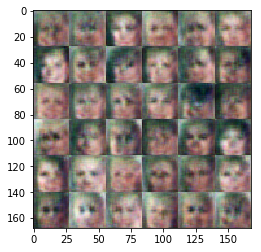

Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.7894... Generator Loss: 0.2637
Epoch 1/2... Discriminator Loss: 0.3657... Generator Loss: 2.5181
Epoch 1/2... Discriminator Loss: 1.8557... Generator Loss: 0.2438
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 3.1804
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 2.0639
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 2.6335


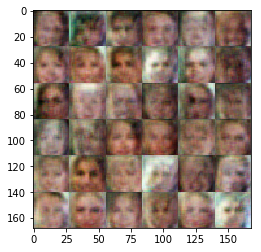

Epoch 1/2... Discriminator Loss: 0.3234... Generator Loss: 2.2161
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 1.4398
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 2.0313... Generator Loss: 0.2093
Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 1.7481
Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 1.7695
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.5064


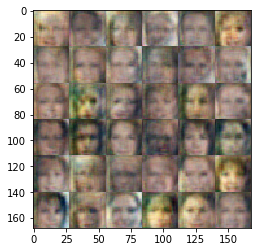

Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 1.3078
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.5814
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.5934


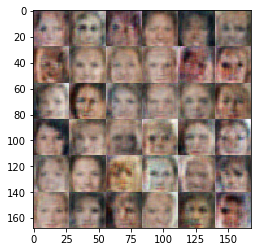

Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.7358
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.6877


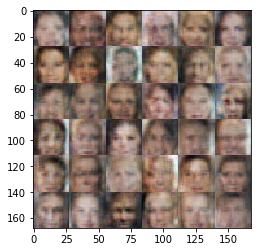

Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.6417


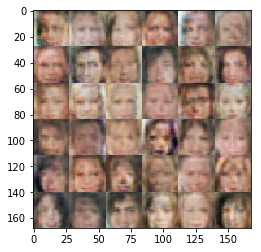

Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.6204
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.7361


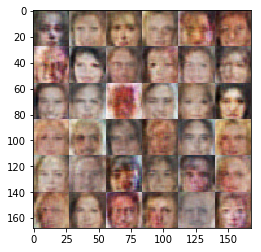

Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 0.8913


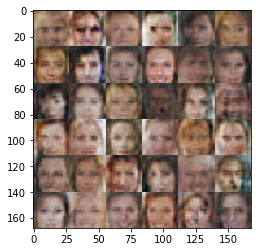

Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.5619
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.9043
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.8342
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 1.1501


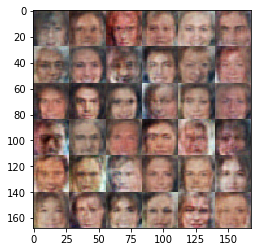

Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.6473
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 0.6054
Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.9035


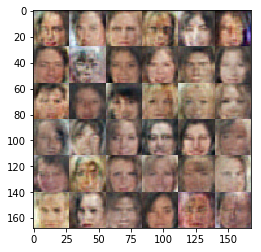

Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.4829


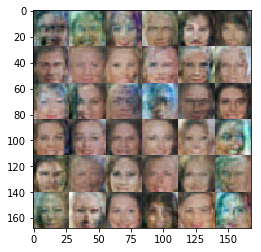

Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.4088
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 0.8118... Generator Loss: 1.2352
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 1.7384
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.6032... Generator Loss: 0.3242


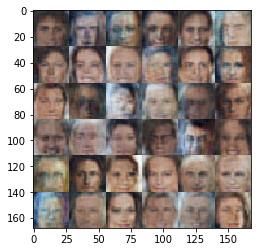

Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.9945
Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.6006


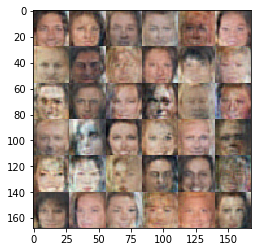

Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.4595
Epoch 1/2... Discriminator Loss: 1.4861... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.9259
Epoch 1/2... Discriminator Loss: 1.5814... Generator Loss: 0.3642
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 1.3016
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.4431
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.5181


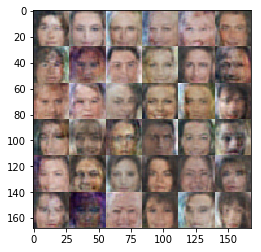

Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.6028
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.5804


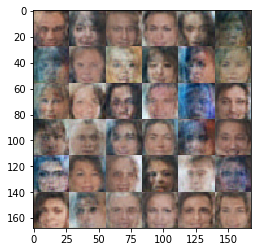

Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 1.2327
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.5357
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.5111
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.5012


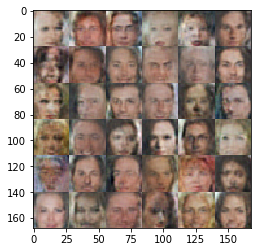

Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 1.1355
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 1.4194
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 1.3993


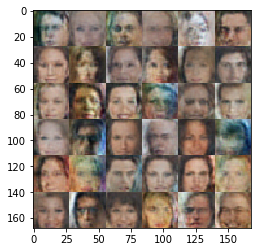

Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 2.3528
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 1.6311... Generator Loss: 0.3459
Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.6478... Generator Loss: 0.2818
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.5216


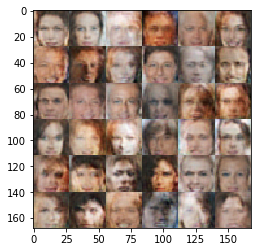

Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.3924
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 1.5203
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.5559
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.1943
Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.6443


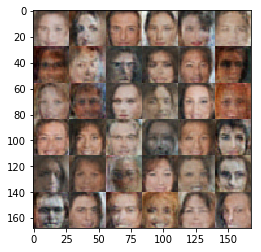

Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 1.2634
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.6045
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6383


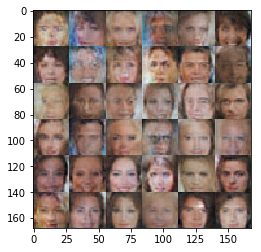

Epoch 2/2... Discriminator Loss: 1.4268... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.8720
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.5714


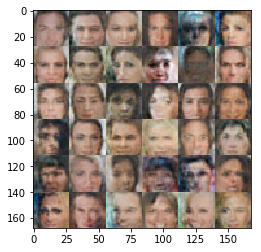

Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.5001
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.7213


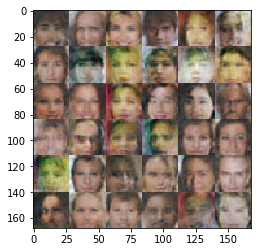

Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.3297
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.5526
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.8832
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 1.4527


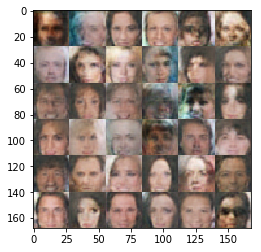

Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 1.9340
Epoch 2/2... Discriminator Loss: 1.5464... Generator Loss: 0.3461
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 1.2916
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 1.2652
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 0.2785... Generator Loss: 3.3494
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 2.3996... Generator Loss: 0.1252
Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 2.5443


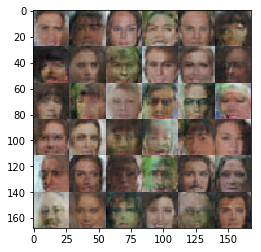

Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 1.1851... Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 0.9521
Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 4.3113
Epoch 2/2... Discriminator Loss: 0.3012... Generator Loss: 4.8029
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 0.4657... Generator Loss: 1.8723
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 0.8110


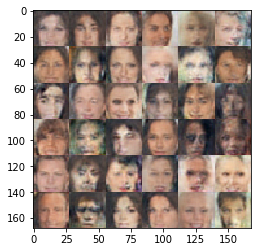

Epoch 2/2... Discriminator Loss: 0.2598... Generator Loss: 2.3808
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.3298
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 0.2284... Generator Loss: 2.8448
Epoch 2/2... Discriminator Loss: 1.4992... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 2.0823... Generator Loss: 0.1677
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 1.8499
Epoch 2/2... Discriminator Loss: 2.0064... Generator Loss: 0.1784


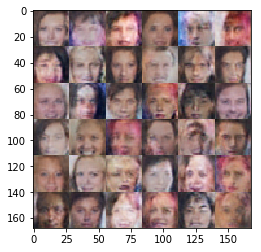

Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 2.6552
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 0.7188
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.5968
Epoch 2/2... Discriminator Loss: 1.5172... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 1.2582
Epoch 2/2... Discriminator Loss: 0.3223... Generator Loss: 3.1490
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 1.9340
Epoch 2/2... Discriminator Loss: 0.2374... Generator Loss: 2.9290


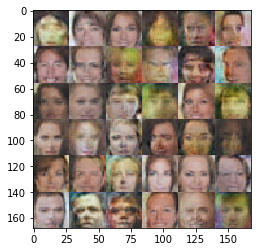

Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 1.6566
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.5177
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.5623
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.5922
Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 1.2457
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.7001... Generator Loss: 0.3696


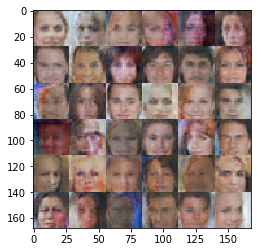

Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 1.5210... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 1.2372
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 1.0757
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.5327
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.7959


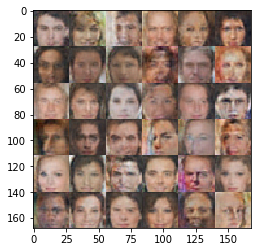

Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 0.2126... Generator Loss: 3.5638
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.1785
Epoch 2/2... Discriminator Loss: 2.1742... Generator Loss: 0.1651
Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 2.4090


In [157]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

#### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.